In [ ]:
import os

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import albumentations as A

from vgg import *
from vgg_utils import *
from visualization import *

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Need functions

In [ ]:
def get_data(input_path, scene, mode='tumor', size=(256, 256)):
    path = os.path.join(input_path, scene)
    images = []

    for image in sorted(os.listdir(path)):
        images.append(imread(os.path.join(path, image)))

    if mode == 'tumor':
        out = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
    else:
        out = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in images]
        
    out = np.array(out, np.float32)
    print(f'loaded {len(out)} {scene}')

    return out

## Getting and Preprocessing Data

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/'

tumor = get_data(input_path, 'tumor_train')
clean = get_data(input_path, 'clean_train')

loaded 1029 tumor_train
loaded 1029 clean_train


In [ ]:
print(f'we have {len(tumor)} tumor images and {len(clean)} clean images')

we have 1029 tumor images and 1029 clean images


## Augmentation

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.8),
                       A.Rotate(limit=(-90, 90)),
                       A.VerticalFlip(p=0.5),
                       A.ChannelShuffle(),
                       A.RandomRotate90()])

In [ ]:
images = np.concatenate((tumor, clean), axis=0)
aug_images = []

for i in range(len(images)):

    transformed = transform(image=images[i])
    aug_images.append(transformed['image'])

In [ ]:
images = np.concatenate((images, aug_images), axis=0)
labels = np.array([1] * 1029 + [0] * 1029 + [1] * 1029 + [0] * 1029)

classes = {0: 'clean', 1: 'tumor'}

In [ ]:
print(f'after augmentation we have {len(images)} images')

after augmentation we have 4116 images


In [ ]:
del tumor, clean, aug_images

## Data Visualization

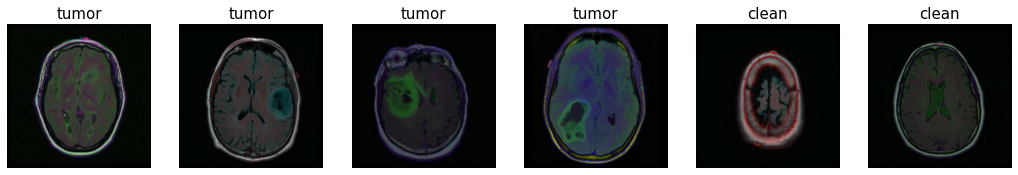

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(0, 6):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.title(classes[labels[i*330]], fontdict={'fontsize': 15})
    plt.imshow(images[i*330])
plt.show()

## Getting Dataloaders

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, shuffle=True)

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(train_data, 3, 1), train_labels)), batch_size=16, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(val_data, 3, 1), val_labels)), batch_size=16, shuffle=True)

In [ ]:
dataloaders = {'train': data_tr, 'val': data_val}

In [ ]:
del images, labels, train_data, train_labels, val_data, val_labels

## Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
CUDA_LAUNCH_BLOCKING=1

In [ ]:
model = VGG().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model = train(model, dataloaders, criterion, optimizer, num_epochs=10)

torch.save(model.state_dict(), '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/vgg.torch')

## Model Evaluation

In [ ]:
model = VGG().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/vgg.torch'))

<All keys matched successfully>

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/gan'

tumor_HR = get_data(input_path, scene='tumor_HR')
clean_HR = get_data(input_path, scene='clean_HR')
images_HR = np.concatenate((tumor_HR, clean_HR), axis=0)

tumor_LR = get_data(input_path, scene='tumor_LR')
clean_LR = get_data(input_path, scene='clean_LR')
images_LR = np.concatenate((tumor_LR, clean_LR), axis=0)

tumor_GT = get_data(input_path, scene='tumor_GT')
clean_GT = get_data(input_path, scene='clean_GT')
images_GT = np.concatenate((tumor_GT, clean_GT), axis=0)

loaded 344 tumor_HR
loaded 344 clean_HR
loaded 344 tumor_LR
loaded 344 clean_LR
loaded 344 tumor_GT
loaded 344 clean_GT


In [ ]:
labels = np.array([1] * 344 + [0] * 344)

In [ ]:
images_LR_dataloader = DataLoader(list(zip(np.rollaxis(images_LR, 3, 1), labels)), batch_size=16, shuffle=True)
images_HR_dataloader = DataLoader(list(zip(np.rollaxis(images_HR, 3, 1), labels)), batch_size=16, shuffle=True)
images_GT_dataloader = DataLoader(list(zip(np.rollaxis(images_GT, 3, 1), labels)), batch_size=16, shuffle=True)

In [ ]:
labels_LR, preds_LR = score_model(model, images_LR_dataloader)
print(f'score on LR images = {round(f1_score(labels_LR, preds_LR), 3)}')

labels_HR, preds_HR = score_model(model, images_HR_dataloader)
print(f'score on HR images = {round(f1_score(labels_HR, preds_HR), 3)}')

labels_GT, preds_GT = score_model(model, images_GT_dataloader)
print(f'score on GT images = {round(f1_score(labels_GT, preds_GT), 3)}')

score on LR images = 0.901
score on HR images = 0.896
score on GT images = 0.909


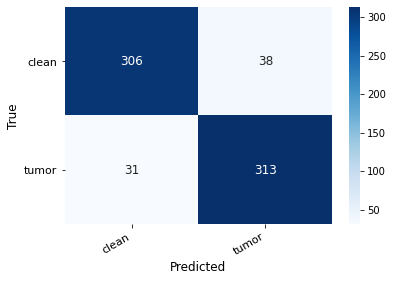

In [ ]:
conf_matr(labels_LR, preds_LR)

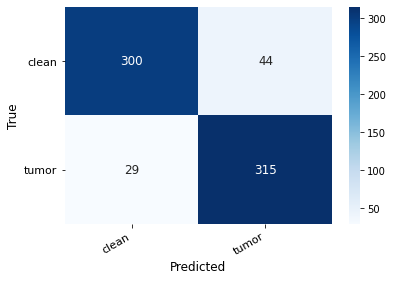

In [ ]:
conf_matr(labels_HR, preds_HR)

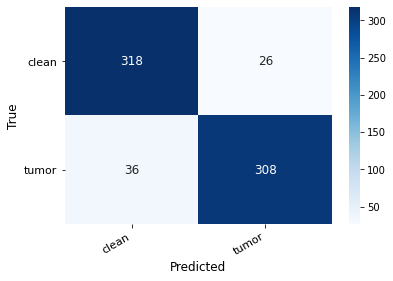

In [ ]:
conf_matr(labels_GT, preds_GT)